In [1]:
import string
import re
from numpy import array
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
#funçao que abre um arquivo de texto
def abre_txt(endereco_arquivo):
    arquivo=open(endereco_arquivo,mode='rt',encoding='utf-8') #mode='rt' é para abrir o arquivo no modo leitura
    texto=arquivo.read()
    arquivo.close()
    return texto

In [5]:
#função que quebra o texto em uma lista de palavras
def lista_palavras(texto):
    lista=texto.strip().split('\n')
    lista=[i.split('\t') for i in lista]
    return lista

In [6]:
dataset=abre_txt('C:/Users/Falcone/Documents/0_MachineLearning/2022.08.27_ProcessamentoDaLinguagem/SistemaDeTraducao/deu.txt')
alemao_ingles=lista_palavras(dataset)
alemao_ingles=array(alemao_ingles)

In [7]:
#pegando apenas uma parte do dataset, para poupar processamento
alemao_ingles=alemao_ingles[:50000,:]

In [8]:
alemao_ingles.shape

(50000, 3)

In [9]:
alemao_ingles[24000]

array(['I failed the exam.', 'Ich habe die Prüfung nicht bestanden.',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #258076 (CK) & #657323 (al_ex_an_der)'],
      dtype='<U537')

In [10]:
cont=0
for i in alemao_ingles[:,1]:
    print(i)
    cont+=1
    if cont>5:
        break

Geh.
Hallo!
Grüß Gott!
Lauf!
Lauf!
Potzdonner!


In [11]:
#removendo pontuaçoes do texto
alemao_ingles[:,0]=[re.sub('[^\w\s]','',s) for s in alemao_ingles[:,0]]
alemao_ingles[:,1]=[re.sub('[^\w\s]','',s) for s in alemao_ingles[:,1]]

In [12]:
cont=0
for i in alemao_ingles[:,1]:
    print(i)
    cont+=1
    if cont>5:
        break

Geh
Hallo
Grüß Gott
Lauf
Lauf
Potzdonner


In [13]:
#transformando tudo para minusculas
for i in range(len(alemao_ingles)):
    alemao_ingles[i,0]=alemao_ingles[i,0].lower()
    alemao_ingles[i,1]=alemao_ingles[i,1].lower()

Maximo comprimento ingles: 6
Maximo comprimento alemao: 15


array([[<AxesSubplot:title={'center':'ingles'}>,
        <AxesSubplot:title={'center':'alemao'}>]], dtype=object)

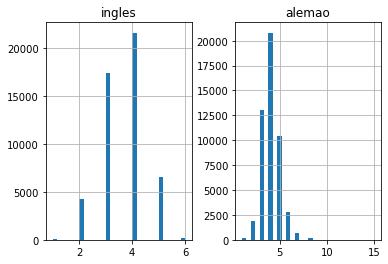

In [14]:
#visualizando o tamanho das sentenças em cada idioma
ingles=[]
alemao=[]

for i in alemao_ingles[:,0]:
    ingles.append(len(i.split()))
    
for i in alemao_ingles[:,1]:
    alemao.append(len(i.split()))
    
df=pd.DataFrame({'ingles':ingles, 'alemao':alemao})

tamanho_max_ingles=df['ingles'].max()
tamanho_max_alemao=df['alemao'].max()

print('Maximo comprimento ingles:', tamanho_max_ingles)
print('Maximo comprimento alemao:', tamanho_max_alemao)

#visualizando um histograma de cada idioma
df.hist(bins=30)

In [15]:
#função que tokeniza as palavras
def tokenizador(frases):
    tokenizador=Tokenizer()
    tokenizador.fit_on_texts(frases)
    return tokenizador

In [16]:
#tokenizador ingles
tokenizador_ingles=tokenizador(alemao_ingles[:,0])
tamanho_vocabulario_ingles=len(tokenizador_ingles.word_index)+1
print('Tamanho do vocabulario Ingles:',tamanho_vocabulario_ingles)

Tamanho do vocabulario Ingles: 6124


In [17]:
tokenizador_ingles

In [18]:
#tokenizador alemao
tokenizador_alemao=tokenizador(alemao_ingles[:,1])
tamanho_vocabulario_alemao=len(tokenizador_alemao.word_index)+1
print('Tamanho do vocabulario Alemao:',tamanho_vocabulario_alemao)

Tamanho do vocabulario Alemao: 10003


In [19]:
def encoder_frases(tokenizador,comprimento,frases):
    frases_tokenizadas=tokenizador.texts_to_sequences(frases)
    frases_tokenizadas=pad_sequences(frases_tokenizadas,maxlen=comprimento,padding='post')
    return frases_tokenizadas

In [20]:
from sklearn.model_selection import train_test_split
treino,teste=train_test_split(alemao_ingles,test_size=0.2,shuffle=False)
#Inseri o parametro shuffle, pois nao quero embaralhar as amostras para poder comparar treinamentos com diferentes
#quantidades de epocas

In [21]:
#colocando os textos em alemao como variaveis preditoras e os textos em ingles como variaveis target
x_treino=encoder_frases(tokenizador_alemao,tamanho_max_alemao,treino[:,1])
y_treino=encoder_frases(tokenizador_ingles,tamanho_max_ingles,treino[:,0])

x_teste=encoder_frases(tokenizador_alemao,tamanho_max_alemao,teste[:,1])
y_teste=encoder_frases(tokenizador_ingles,tamanho_max_ingles,teste[:,0])

In [22]:
x_treino.shape

(40000, 15)

In [23]:
y_treino.shape

(40000, 6)

In [24]:
x_teste.shape

(10000, 15)

In [25]:
from tensorflow.keras.models import load_model

In [26]:
# load model
modelo = load_model('C:/Users/Falcone/Documents/0_MachineLearning/2022.08.27_ProcessamentoDaLinguagem/SistemaDeTraducao/modelo_40epocas.h5')
# summarize model.
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 15, 500)           5001500   
                                                                 
 lstm (LSTM)                 (None, 500)               2002000   
                                                                 
 repeat_vector (RepeatVector  (None, 6, 500)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6, 500)            2002000   
                                                                 
 dense (Dense)               (None, 6, 6124)           3068124   
                                                                 
Total params: 12,073,624
Trainable params: 12,073,624
Non-trainable params: 0
____________________________________________

In [30]:
# evaluate the model
score = modelo.evaluate(x_treino, y_treino, verbose=0)
#print("%s: %.2f%%" % (modelo.metrics_names[0], score*100))

In [31]:
print(score)

0.8812296986579895


In [58]:
#print("%s: %.2f%%" % (modelo.metrics_names[0], score*100)) #codigo se o parametro fosse accuracy
print("%s: %.2f" % (modelo.metrics_names[0],score)) #formato correto para loss e nao accuracy

loss: 0.88


## Previsoes do dataset de treino

In [59]:
previsoes_treino=modelo.predict(x_treino)

1250/1250 [==============================] - 84s 67ms/step


In [60]:
import numpy as np
previsoes_resumida=[]
for i in range(len(x_treino)):
    previsao_linha=np.argmax(previsoes_treino[i],1)
    previsoes_resumida.append(previsao_linha)

In [61]:
previsoes_resumida_array=np.array(previsoes_resumida)
previsoes=previsoes_resumida_array

In [62]:
# Criando uma função que retorna as palavras a partir de seus números de tokenização:
def coleta_palavra(token, tokenizador):
    for palavra, index in tokenizador.word_index.items():
        if index == token:
            return palavra
    return None

In [63]:
# Transformando todas as predições em palavras:
texto_previsto = []
for frase in previsoes: # para cada frase prevista
    sentenca = []
    for token in range(len(frase)): # para cada token previsto dentro de uma frase
        palavra_ingles = coleta_palavra(frase[token], tokenizador_ingles) # palavra inglês
        if(palavra_ingles == None):
            sentenca.append('')
        else:
            sentenca.append(palavra_ingles)

    texto_previsto.append(' '.join(sentenca))

In [64]:
#criando um dataset que contem as frases em ingles do dataset de teste e as respectivas previsoes
#do modelo
df_previsoes_treino=pd.DataFrame({'Referencias':treino[:,0],'Previsoes': texto_previsto})

In [65]:
#visualizando alguns resultados
df_previsoes_treino.sample(10)

,Referencias,Previsoes
1840,stay close,stay close
16871,come take a look,come take of this
22993,do you see a rose,do you have a rose
13067,i lost that bet,i love the bet
23994,i drove them home,i drove to home
24916,im first in line,im first in line
22641,are your lips dry,are your lips dry
10892,tom isnt tidy,tom isnt tidy
19676,put the gun down,put the gun down
3092,this is tom,this is tom


In [66]:
# aplicando o BLEU SCORE em varias sentenças
from nltk.translate.bleu_score import corpus_bleu #usado para calcular varias sentenças
previsoes=[]
for i in df_previsoes_treino['Previsoes']:
    previsoes.append(i.split())#i.split() irá quebrar cada frase em uma lista de palavras individuais

referencias=[]
for i in df_previsoes_treino['Referencias']:
    lista=[i.split()]
    referencias.append(lista)

In [78]:
score=corpus_bleu(referencias,previsoes,weights=(0.33,0.33,0.33,0))
print("%.2f%%" % (score))

0.61%


## Previsoes do dataset de teste

In [79]:
x_teste.shape

(10000, 15)

In [80]:
previsoes=modelo.predict(x_teste)

313/313 [==============================] - 22s 66ms/step


In [81]:
import numpy as np
previsoes_resumida=[]
for i in range(len(x_teste)):
    #print('i:',i)
    previsao_linha=np.argmax(previsoes[i],1)
    previsoes_resumida.append(previsao_linha)
    #print(previsoes_resumida)

In [82]:
previsoes_resumida_array=np.array(previsoes_resumida)

In [83]:
previsoes_resumida_array.shape

(10000, 6)

In [84]:
previsoes_resumida_array

array([[   4,    1, 1710,    0,    0,    0],
       [  44,    1,   29,  169,    0,    0],
       [   4,    1,  253,  253,    0,    0],
       ...,
       [ 104,  749,  108,    0,    0,    0],
       [ 415,  517,    0,    0,    0,    0],
       [ 104,  273,    0,    0,    0,    0]], dtype=int64)

In [85]:
previsoes=previsoes_resumida_array

In [86]:
# Criando uma função que retorna as palavras a partir de seus números de tokenização:
def coleta_palavra(token, tokenizador):
    for palavra, index in tokenizador.word_index.items():
        if index == token:
            return palavra
    return None

# Transformando todas as predições em palavras:
texto_previsto = []
for frase in previsoes: # para cada frase prevista
    sentenca = []
    for token in range(len(frase)): # para cada token previsto dentro de uma frase
        palavra_ingles = coleta_palavra(frase[token], tokenizador_ingles) # palavra inglês
        if(palavra_ingles == None):
            sentenca.append('')
        else:
            sentenca.append(palavra_ingles)

    texto_previsto.append(' '.join(sentenca))

In [87]:
#criando um dataset que contem as frases em ingles do dataset de teste e as respectivas previsoes
#do modelo
df_previsoes=pd.DataFrame({'Referencias':teste[:,0],'Previsoes': texto_previsto})

In [88]:
#visualizando alguns resultados
df_previsoes

,Referencias,Previsoes
0,is tom an alcoholic,is tom autistic
1,is tom back already,has tom go yet
2,is tom doing better,is tom better better
3,is tom going to die,has tom help
4,is tom goodlooking,is tom well
...,...,...
9995,theyre best friends,they are friends
9996,theyre closed today,they went nearby
9997,theyre coming again,theyre winning again
9998,theyre coming again,hold fire


In [89]:
#mostrando aleatoriamente 10 frases do dataset
df_previsoes.sample(10)

,Referencias,Previsoes
3859,when do you want it,when did it end
676,my room key please,the this
5835,he emptied his glass,he has a day
8072,im right beside you,i agree to you
8067,im really surprised,im really
8848,my dog is not so big,this my is new
5382,do you want to dance,do you wanna talk
5607,excuse my clumsiness,get me some
7234,i owe him 50000 yen,i glad with him
802,now eat your supper,watch your juice


In [90]:
df_previsoes.loc[[7430]]

,Referencias,Previsoes
7430,i thought youd left,i made her mad


In [91]:
# aplicando o BLEU SCORE em varias sentenças
from nltk.translate.bleu_score import corpus_bleu #usado para calcular varias sentenças
previsoes=[]
for i in df_previsoes['Previsoes']:
    previsoes.append(i.split())#i.split() irá quebrar cada frase em uma lista de palavras individuais

referencias=[]
for i in df_previsoes['Referencias']:
    lista=[i.split()]
    referencias.append(lista)

In [92]:
score=corpus_bleu(referencias,previsoes,weights=(0.33,0.33,0.33,0))
print("%.2f%%" % (score))

0.19%
